Time series forcasting with deep learning and lstm autoencoders

Predict future sales

In [1]:
import os, warnings, random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import tensorflow.keras.layers as L 
from tensorflow.keras import optimizers, Sequential, Model

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
test = pd.read_csv('/Users/nuthankumar/Downloads/competitive-data-science-predict-future-sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('/Users/nuthankumar/Downloads/competitive-data-science-predict-future-sales/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('/Users/nuthankumar/Downloads/competitive-data-science-predict-future-sales/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('/Users/nuthankumar/Downloads/competitive-data-science-predict-future-sales/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('/Users/nuthankumar/Downloads/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

Join Data sets

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

Lets look at the raw data

In [5]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head().T)
display(train.describe())

Train rows: 2935849
Train columns: 10


,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


Time period of the dataset

In [6]:
print(f"Min date from the train set : {train['date'].min().date()}")
print(f"Min date from the train set : {train['date'].max().date()}")

Min date from the train set : 2013-01-01
Min date from the train set : 2015-12-10


Leaving only the 'shop_id' and 'item_id' that exits in the test set to have more accurate results

In [7]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
#only shops that exis in the test set
train = train[train['shop_id'].isin(test_shop_ids)]
#only items that exis in the test set
train = train[train['item_id'].isin(test_item_ids)]

Data preprocessing

Dropping all features but 'item_cnt_month' because I will be using only as a univariate time-series.
We are also agregating data for month because I'm predicting total sale for every product and store in the next month 
ALso im leaving only monthy 'item_cnt'>=0 and <=20, as this seems to be the distribution of the test set.

In [8]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day': ['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')

#label
train_monthly['item_cnt_month']= train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [9]:
display(train_monthly.head(10).T)
display(train_monthly.describe().T)

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


Time series Processing

In [10]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt', fill_value=0).reset_index()

In [17]:
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [19]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month- (first_month + serie_size))+1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size+1):
            serie.append(row[month1 + first_month+month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


Droping identifier columns as we dont neeed them anymore.


In [20]:
data_series = data_series.drop(['item_id','shop_id'], axis=1)

Train and validation sets

In [21]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [23]:
print('Train set', train.shape)
print('validation set', valid.shape)
train.head()

Train set (200327, 12)
validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


Reshape data

In [24]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


Regular LSTM model

In [27]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

2022-03-31 21:03:42.338429: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 12, 6)             408       
                                                                 
 lstm_2 (LSTM)               (None, 1)                 32        
                                                                 
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,061
Trainable params: 1,061
Non-trainabl

In [28]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 20s - loss: 1.5067 - val_loss: 1.3121 - 20s/epoch - 13ms/step
Epoch 2/20
1566/1566 - 16s - loss: 1.3280 - val_loss: 1.2557 - 16s/epoch - 10ms/step
Epoch 3/20
1566/1566 - 16s - loss: 1.2745 - val_loss: 1.2244 - 16s/epoch - 10ms/step
Epoch 4/20
1566/1566 - 16s - loss: 1.2355 - val_loss: 1.1961 - 16s/epoch - 10ms/step
Epoch 5/20
1566/1566 - 16s - loss: 1.2046 - val_loss: 1.1762 - 16s/epoch - 10ms/step
Epoch 6/20
1566/1566 - 16s - loss: 1.1770 - val_loss: 1.1576 - 16s/epoch - 10ms/step
Epoch 7/20
1566/1566 - 16s - loss: 1.1703 - val_loss: 1.1531 - 16s/epoch - 10ms/step
Epoch 8/20
1566/1566 - 27s - loss: 1.1678 - val_loss: 1.1512 - 27s/epoch - 17ms/step
Epoch 9/20
1566/1566 - 16s - loss: 1.1665 - val_loss: 1.1484 - 16s/epoch - 10ms/step
Epoch 10/20
1566/1566 - 16s - loss: 1.1653 - val_loss: 1.1484 - 16s/epoch - 10ms/step
Epoch 11/20
1566/1566 - 16s - loss: 1.1643 - val_loss: 1.1487 - 16s/epoch - 11ms/step
Epoch 12/20
1566/1566 - 17s - loss: 1.1637 - val_loss: 1.1465 -

LSTM Autoencoder

In [29]:
encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(1, activation='relu'))
encoder_decoder.add(L.RepeatVector(serie_size))
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 12)            672       
                                                                 
 lstm_4 (LSTM)               (None, 12, 6)             456       
                                                                 
 lstm_5 (LSTM)               (None, 1)                 32        
                                                                 
 repeat_vector (RepeatVector  (None, 12, 1)            0         
 )                                                               
                                                                 
 lstm_6 (LSTM)               (None, 12, 12)            672       
                                                                 
 lstm_7 (LSTM)               (None, 12, 6)             456       
                                                      

In [30]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train,batch_size=batch, epochs=epochs, verbose=1)

Epoch 1/20
1566/1566 [==============================] - 33s 19ms/step - loss: 1.5515
Epoch 2/20
1566/1566 [==============================] - 27s 17ms/step - loss: 1.1076
Epoch 3/20
1566/1566 [==============================] - 27s 17ms/step - loss: 1.0432
Epoch 4/20
1566/1566 [==============================] - 28s 18ms/step - loss: 1.0178
Epoch 5/20
1566/1566 [==============================] - 26s 17ms/step - loss: 1.0000
Epoch 6/20
1566/1566 [==============================] - 26s 17ms/step - loss: 0.9869
Epoch 7/20
1566/1566 [==============================] - 26s 17ms/step - loss: 0.9742
Epoch 8/20
1566/1566 [==============================] - 26s 17ms/step - loss: 0.9634
Epoch 9/20
1566/1566 [==============================] - 26s 17ms/step - loss: 0.9526
Epoch 10/20
1566/1566 [==============================] - 26s 17ms/step - loss: 0.9527
Epoch 11/20
1566/1566 [==============================] - 26s 17ms/step - loss: 0.9445
Epoch 12/20
1566/1566 [==============================] - 26s 17

Lets take a loot at the layers of the encoder_decoder model:

In [32]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

In [33]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]
 [2.747679]]


As you can see this is just the same value repeated some times to match the same shape of the model input.

#### TimeDistributed layer
* This layer is more common, sometimes is used when you want to mix RNN layers with other kind of layers.
* We could output the model with another LSTM layer with one neuron and "return_sequences=True" parameter, but using a "TimeDistributed" layer wrapping a "Dense" layer we will have the same weights for each outputted time-step.

In [34]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

Time distributed output shape (1, 12, 6)
Time distributed output sample
[[3.90755087e-02 0.00000000e+00 5.56699652e-03 9.97025445e-02
  1.10898905e-01 9.07551125e-02]
 [2.12882794e-02 0.00000000e+00 3.18879932e-02 1.27165094e-01
  2.40225673e-01 2.08609134e-01]
 [1.02650458e-02 0.00000000e+00 8.62390622e-02 7.36518875e-02
  3.30448955e-01 2.95649350e-01]
 [4.39583091e-03 1.22000929e-02 1.49339169e-01 4.00770456e-02
  3.83188725e-01 3.22746754e-01]
 [1.75029365e-03 2.62914691e-02 2.02116594e-01 2.08721086e-02
  4.06380117e-01 3.13672453e-01]
 [6.80689933e-04 3.79995070e-02 2.38819122e-01 1.06401043e-02
  4.07390416e-01 2.97004461e-01]
 [2.68084113e-04 4.97392304e-02 2.64031798e-01 5.40401926e-03
  3.94846916e-01 2.94934541e-01]
 [1.06172403e-04 6.29271790e-02 2.82324731e-01 2.72273296e-03
  3.75187725e-01 3.02153379e-01]
 [4.19471180e-05 7.68128037e-02 2.95726687e-01 1.35760847e-03
  3.51167589e-01 3.10950965e-01]
 [1.64772355e-05 8.96624923e-02 3.04937482e-01 6.70626527e-04
  3.2411873

Defining the encoding model

In [35]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [36]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (200327, 1)
Encoded time-series sample [2.747679]


Add new encoded features to the train and validation sets

In [37]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
207604,0,0,0,0,0,0,0,0,0,0,0,0,2.75,0
45150,0,0,0,0,0,0,0,0,0,0,0,0,2.75,0
143433,0,0,4,2,1,2,2,1,0,0,0,1,67.41,1
202144,0,0,0,0,0,0,0,0,0,0,0,0,2.75,0
136088,0,0,0,0,0,0,0,1,0,0,1,0,3.62,1
121675,0,0,0,0,0,1,0,0,0,0,0,0,3.27,0
185281,0,0,0,0,0,0,0,0,0,0,0,0,2.75,1
70087,0,0,0,0,0,0,0,0,3,0,1,3,8.08,0
105249,0,0,0,0,0,0,0,0,0,0,0,0,2.75,0
183257,0,0,0,0,0,3,0,1,0,0,0,1,5.13,0


#### Now we can use the new encoded feature that is a representation of the whole time-series and train a "less complex" model that does not receives sequenced data as input.

# MLP with LSTM encoded feature
* For the MLP model I'm only using the current month "item_count" and the encoded time-series feature from our LSTM encoder model, the idea is that we won't need the whole series because we already have a column that represents the whole series into a single value (it's like a dimensionality reduction).

In [38]:
last_month = serie_size-1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_valid_encoded = valid['label']
valid.drop('label', axis=1, inplace=True)
X_valid_encoded = valid[[last_month, 'encoded']]

print("train Set", X_train_encoded.shape)
print("validation set", X_valid_encoded.shape)

train Set (200327, 2)
validation set (22259, 2)


In [39]:
X_train_encoded.head()

,11,encoded
207604,0,2.75
45150,0,2.75
143433,1,67.41
202144,0,2.75
136088,0,3.62


In [40]:
mlp_model = Sequential()
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(1))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                30        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [41]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)

Epoch 1/20
1566/1566 - 1s - loss: 31.3249 - val_loss: 1.9453 - 1s/epoch - 894us/step
Epoch 2/20
1566/1566 - 1s - loss: 1.5543 - val_loss: 1.3272 - 997ms/epoch - 637us/step
Epoch 3/20
1566/1566 - 1s - loss: 1.2833 - val_loss: 1.2056 - 993ms/epoch - 634us/step
Epoch 4/20
1566/1566 - 1s - loss: 1.2437 - val_loss: 1.2034 - 1000ms/epoch - 638us/step
Epoch 5/20
1566/1566 - 1s - loss: 1.2405 - val_loss: 1.2096 - 979ms/epoch - 625us/step
Epoch 6/20
1566/1566 - 1s - loss: 1.2400 - val_loss: 1.2005 - 990ms/epoch - 632us/step
Epoch 7/20
1566/1566 - 1s - loss: 1.2397 - val_loss: 1.2004 - 977ms/epoch - 624us/step
Epoch 8/20
1566/1566 - 1s - loss: 1.2388 - val_loss: 1.2131 - 984ms/epoch - 629us/step
Epoch 9/20
1566/1566 - 1s - loss: 1.2374 - val_loss: 1.1979 - 979ms/epoch - 625us/step
Epoch 10/20
1566/1566 - 1s - loss: 1.2341 - val_loss: 1.1948 - 975ms/epoch - 623us/step
Epoch 11/20
1566/1566 - 1s - loss: 1.2302 - val_loss: 1.1904 - 997ms/epoch - 636us/step
Epoch 12/20
1566/1566 - 1s - loss: 1.2285 

# Comparing models
* As you can see I tried to build both models with a similar topology (type/number of layers and neurons), so it could make more sense to compare them.
* The results are pretty close, also they may change a bit depending on the random initialization of the networks weights, so I would say they are very similar in terms of performance.

#### Model training

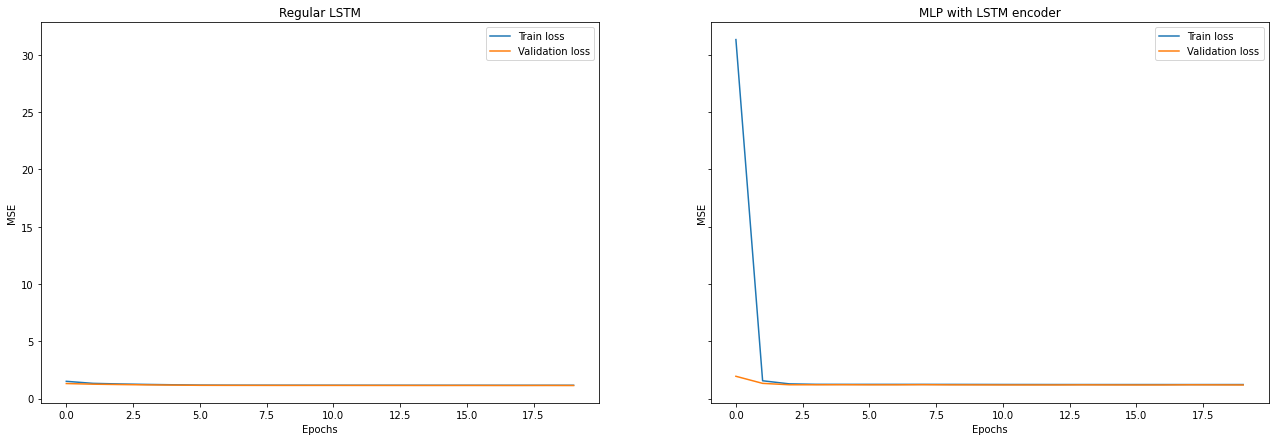

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(mlp_history.history['loss'], label='Train loss')
ax2.plot(mlp_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('MLP with LSTM encoder')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

plt.show()

#### Regular LSTM on train and validation.

In [44]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 1.0764878845121726
Validation rmse: 1.068136247033201


In [45]:
mlp_train_pred2 = mlp_model.predict(X_train_encoded.values)
mlp_val_pred2 = mlp_model.predict(X_valid_encoded.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_encoded, mlp_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_encoded, mlp_val_pred2)))

Train rmse: 1.1052965261435796
Validation rmse: 1.089759781158195


### Build test set
#### Since we have two models I'll build test sets to apply on both of them.

In [46]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Regular LSTM model test predictions
* For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [48]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Reshape data.
* Time-series shape **(data points, time-steps, features)**.

In [49]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


In [50]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

In [52]:
test_encoded = encoder.predict(X_test_reshaped)

In [53]:
X_test['encoded'] = test_encoded
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33,encoded
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,5.12
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.75
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00,7.46
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3.09
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.75


In [54]:
X_test_encoded = X_test[[33, 'encoded']]
print("Train set", X_test_encoded.shape)
X_test_encoded.head()

Train set (214200, 2)


,33,encoded
0,0.00,5.12
1,0.00,2.75
2,1.00,7.46
3,0.00,3.09
4,0.00,2.75


making predictions

In [55]:

mlp_test_pred = mlp_model.predict(X_test_encoded)

In [56]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
lstm_prediction.to_csv('lstm_submission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.55
1,1,0.49
2,2,0.85
3,3,0.17
4,4,0.49
5,5,0.44
6,6,0.98
7,7,0.17
8,8,1.22
9,9,0.49


In [57]:
mlp_prediction = pd.DataFrame(test['ID'], columns=['ID'])
mlp_prediction['item_cnt_month'] = mlp_test_pred.clip(0., 20.)
mlp_prediction.to_csv('mlp_submission.csv', index=False)
mlp_prediction.head(10)

,ID,item_cnt_month
0,0,0.29
1,1,0.28
2,2,0.41
3,3,0.28
4,4,0.28
5,5,0.40
6,6,0.87
7,7,0.29
8,8,0.69
9,9,0.28
